In [1]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from keybert import KeyBERT
import re
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
import torch
from lavis.models import load_model_and_preprocess
import base64
from IPython.display import Image as IImage
from PIL import Image



In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans


In [3]:
import glob
import json
import os.path
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

In [4]:
lemmatizer = WordNetLemmatizer()

In [5]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
def get_sim(u,v):

    emb1 = embedder.encode(u)
    if isinstance(v, list):
        v = ' '.join(v)
    emb2 = embedder.encode(v)
    
    return float(util.cos_sim(emb1, emb2)[0][0])

# Image

In [7]:
root_dir = '/home/xtest/projects/missed_q50_over_avg'
column_names = ['uniq_id', 'image_id', 'captions', 'labels', 'image']


In [8]:
train = pd.read_csv(f'{root_dir}/caption_stage1_train.tsv', names=column_names, sep="\t")
train

,uniq_id,image_id,captions,labels,image
0,1072,1072,Tram in Athens,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,694,694,Public transport in action pedestrians boardi...,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,556,556,Union Station tunnel as seen in Everybodys Fin...,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,1560,1560,English Tram 209 Line 2 February 7 2012,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,161,161,Public Transportation English Public Transport...,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
...,...,...,...,...,...
2985,731,731,English Annes Beach broadwalk that connects t...,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2986,558,558,Doon Campus Sidewalk English This image shows ...,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2987,2126,2126,English Main Street in downtown Childress,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2988,1571,1571,English Rabat walk 2017,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [9]:
train_2 = pd.read_csv(f'{root_dir}/caption_stage2_train.tsv', names=column_names, sep="\t")


In [10]:
val = pd.read_csv(f'{root_dir}/caption_val.tsv', names=column_names, sep="\t")


In [11]:
images_df = pd.concat([train, train_2, val])
images_df.drop('uniq_id', axis=1, inplace=True)
images_df.drop('labels', axis=1, inplace=True)
images_df.drop('image_id', axis=1, inplace=True)
images_df.reset_index(drop=True, inplace=True)

images_df

,captions,image
0,Tram in Athens,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,Public transport in action pedestrians boardi...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,Union Station tunnel as seen in Everybodys Fin...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,English Tram 209 Line 2 February 7 2012,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,Public Transportation English Public Transport...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
...,...,...
4149,In The Park,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4150,English Davis Park Aug 20 2009 photo by Stevan,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4151,Landscaping in parking lot English Planters at...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4152,English An individual at Blackbuck National P...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [12]:
images_dir = '/home/xtest/projects/missed_q50_over_avg/images'
! mkdir -p /home/xtest/projects/missed_q50_over_avg/images

In [13]:
images_df['img_id'] = f'{images_dir}/' + images_df.index.astype(str) + '.jpg'
images_df

,captions,image,img_id
0,Tram in Athens,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,/home/xtest/projects/missed_q50_over_avg/image...
1,Public transport in action pedestrians boardi...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,/home/xtest/projects/missed_q50_over_avg/image...
2,Union Station tunnel as seen in Everybodys Fin...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,/home/xtest/projects/missed_q50_over_avg/image...
3,English Tram 209 Line 2 February 7 2012,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,/home/xtest/projects/missed_q50_over_avg/image...
4,Public Transportation English Public Transport...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,/home/xtest/projects/missed_q50_over_avg/image...
...,...,...,...
4149,In The Park,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,/home/xtest/projects/missed_q50_over_avg/image...
4150,English Davis Park Aug 20 2009 photo by Stevan,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,/home/xtest/projects/missed_q50_over_avg/image...
4151,Landscaping in parking lot English Planters at...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,/home/xtest/projects/missed_q50_over_avg/image...
4152,English An individual at Blackbuck National P...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,/home/xtest/projects/missed_q50_over_avg/image...


In [14]:
for index, row in images_df.iterrows():
#     print(f'Row {index}:')
#     print(row[2])
    image_64_decode = base64.b64decode(row[1]) 
    image_result = open(f'{images_dir}/{index}.jpg', 'wb')
    image_result.write(image_64_decode)
    image_result.close()
#     break

In [15]:
images_df.drop('image', axis=1, inplace=True)
images_df

,captions,img_id
0,Tram in Athens,/home/xtest/projects/missed_q50_over_avg/image...
1,Public transport in action pedestrians boardi...,/home/xtest/projects/missed_q50_over_avg/image...
2,Union Station tunnel as seen in Everybodys Fin...,/home/xtest/projects/missed_q50_over_avg/image...
3,English Tram 209 Line 2 February 7 2012,/home/xtest/projects/missed_q50_over_avg/image...
4,Public Transportation English Public Transport...,/home/xtest/projects/missed_q50_over_avg/image...
...,...,...
4149,In The Park,/home/xtest/projects/missed_q50_over_avg/image...
4150,English Davis Park Aug 20 2009 photo by Stevan,/home/xtest/projects/missed_q50_over_avg/image...
4151,Landscaping in parking lot English Planters at...,/home/xtest/projects/missed_q50_over_avg/image...
4152,English An individual at Blackbuck National P...,/home/xtest/projects/missed_q50_over_avg/image...


In [16]:
base_url = "https://aise.blob.core.windows.net/aise1"
images_df['img_url'] = f'{base_url}/' + images_df.index.astype(str) + '.jpg'
images_df

,captions,img_id,img_url
0,Tram in Athens,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/0.jpg
1,Public transport in action pedestrians boardi...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/1.jpg
2,Union Station tunnel as seen in Everybodys Fin...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/2.jpg
3,English Tram 209 Line 2 February 7 2012,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/3.jpg
4,Public Transportation English Public Transport...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4.jpg
...,...,...,...
4149,In The Park,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4149.jpg
4150,English Davis Park Aug 20 2009 photo by Stevan,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4150.jpg
4151,Landscaping in parking lot English Planters at...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4151.jpg
4152,English An individual at Blackbuck National P...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4152.jpg


In [17]:
images_df.at[3500,'captions']

' English Pedestrian bridge on Winton Woods walking trail'

In [18]:
images_df.at[3500,'img_url']

'https://aise.blob.core.windows.net/aise1/3500.jpg'

In [19]:
images_df.at[3500,'img_id']

'/home/xtest/projects/missed_q50_over_avg/images/3500.jpg'

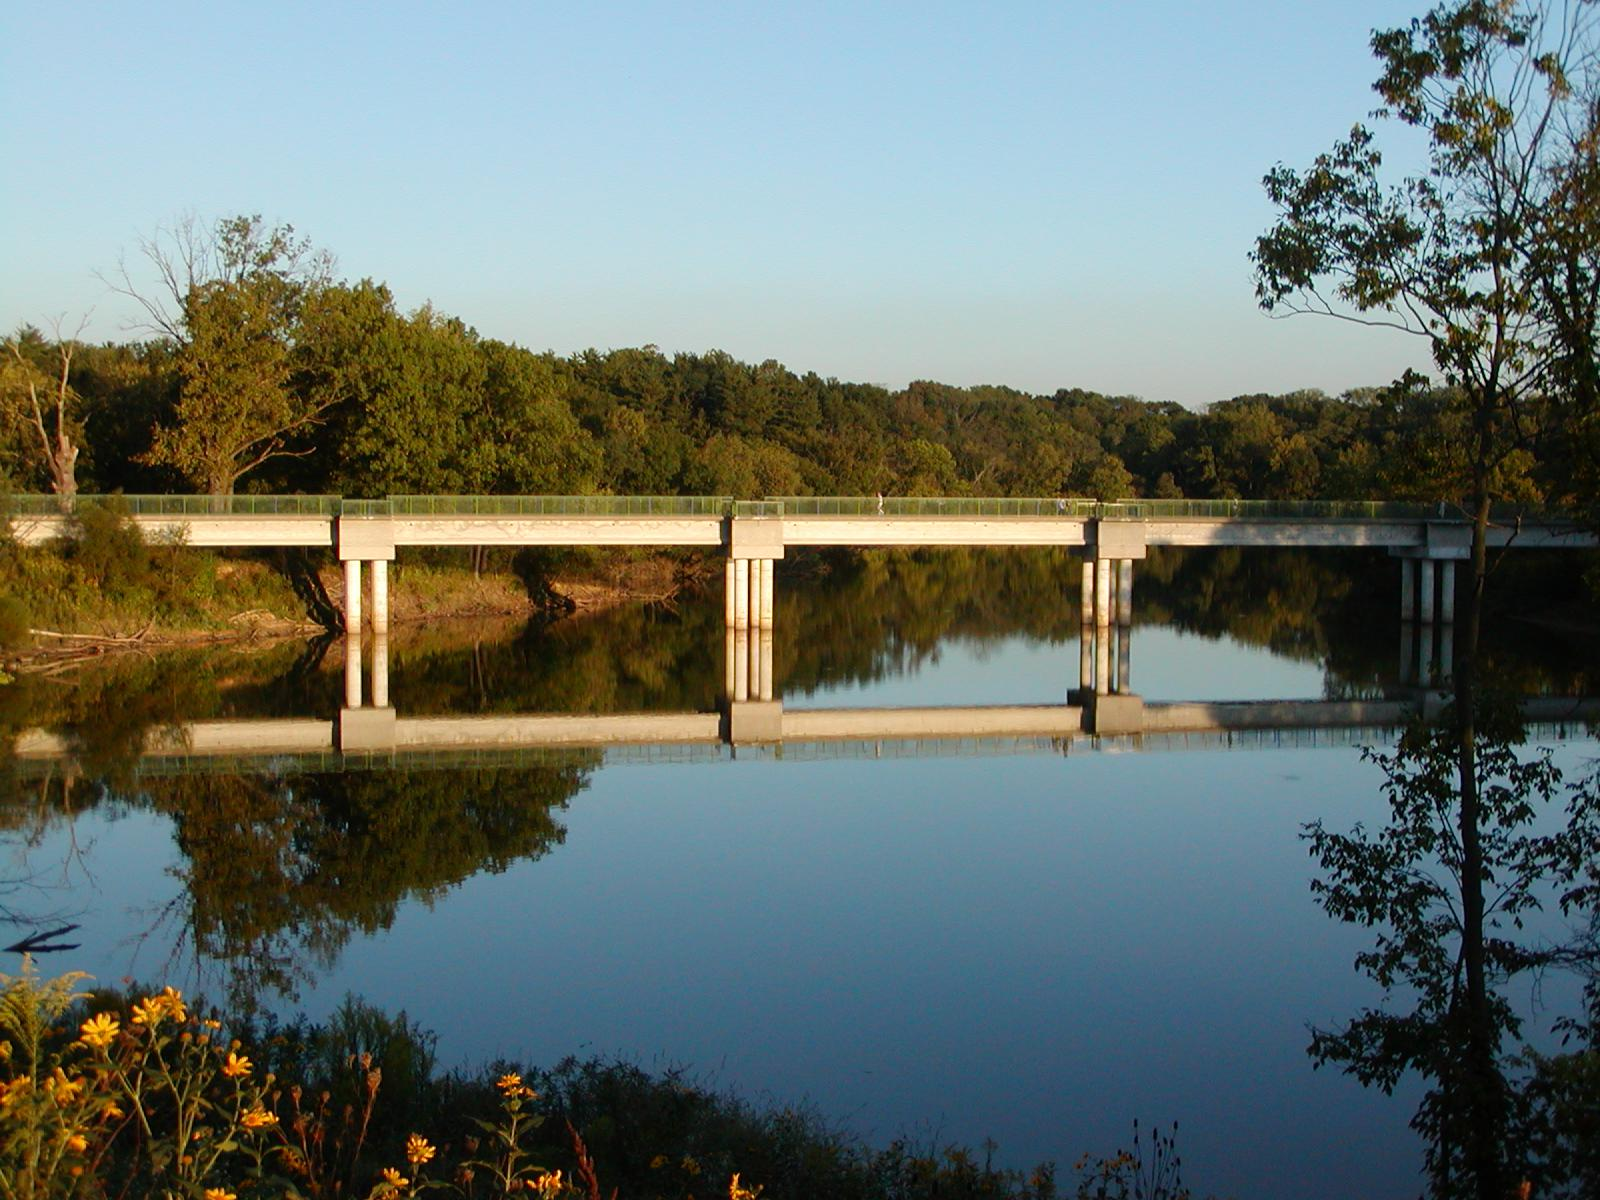

In [20]:
display(IImage(filename=f'{images_dir}/3500.jpg'))

In [73]:
# create_zip_file(images_dir)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [22]:
print(device)

cuda


In [23]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_feature_extractor", model_type="base", is_eval=True, device=device)

In [25]:
images = images_df.img_id.to_list()
docs = images_df.captions.to_list()

In [26]:
print(len(images))
print(len(docs))

4154
4154


In [27]:
embeddings = []
for i in tqdm(range(len(images))):
    raw_image = vis_processors["eval"](Image.open(images[i]).convert("RGB")).unsqueeze(0).to(device)
    text_input = txt_processors["eval"](docs[i])
    sample = {'image': raw_image, 
              'text_input': [text_input]}
    
    features_image = model.extract_features(sample, mode="image")
#     features_text = model.extract_features(sample, mode="text")
#     features_multimodal = model.extract_features(sample)
    img_emb = features_image.image_embeds[:,0,:].cpu().numpy()
#     img_emb = features_multimodal.multimodal_embeds[:,0,:].cpu().numpy()
    embeddings.extend(img_emb.tolist())


embeddings = np.array(embeddings)

100%|██████████| 4154/4154 [05:04<00:00, 13.65it/s]


In [82]:
len(docs)

4154

In [83]:
all_data = []
for idx in cluster_data:
    all_data.extend(cluster_data[idx]['data'])
len(all_data)

326636

In [84]:
vocabulary = CountVectorizer().fit(all_data).vocabulary_
pattern = re.compile(r"^[a-zA-Z0-9]+$")
kw_1 = [word for word in list(vocabulary.keys()) if pattern.match(word)]
len(kw_1)

313370

In [97]:
# vocabulary = CountVectorizer().fit(cluster_data[0]['data']).vocabulary_
# len(vocabulary)

51974

In [ ]:
# vocabulary

In [116]:
# kw_model = KeyBERT()
# keywords = kw_model.extract_keywords(cluster_data[0]['data'])

In [117]:
# vocabulary_1 = [k[0] for keyword in keywords for k in keyword]
# vocabulary_1 = list(set(vocabulary_1))

In [229]:
# lem_keys = []
# for el in vocabulary_1:
#     w = lemmatizer.lemmatize(el, get_wordnet_pos(el))
#     lem_keys.append(w)
# lem_keys = list(set(lem_keys))

In [230]:
# sim_keys = []
# for el in lem_keys:
#     sim_keys.append(get_sim(el, 'pedestrian'))

In [ ]:
# df_k = pd.DataFrame({'words':lem_keys, 'score':sim_keys})
# df_k = df_k.sort_values(by=['score'], ascending=False)
# df_k

In [85]:

vectorizer_model = CountVectorizer(stop_words="english", vocabulary=kw_1, ngram_range=(1, 3))

representation_model = MaximalMarginalRelevance(diversity=0.5)


In [ ]:
# topic_model_img = BERTopic(vectorizer_model=vectorizer_model,
#                            representation_model=representation_model)
# topics_img, probs_img = topic_model_img.fit_transform(docs, embeddings)
# images_df["topic"] = topics_img

In [86]:

topic_model_img = BERTopic(vectorizer_model=vectorizer_model, language='multilingual',
                           representation_model=representation_model, calculate_probabilities=True)
topics_img, probs_img = topic_model_img.fit_transform(docs, embeddings)
images_df["topic"] = topics_img

/home/xtest/miniconda3/envs/lavis/lib/python3.8/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


In [87]:
print(probs_img)

[[1.00000000e+000 3.25848993e-307 4.59409171e-308 ... 8.10559104e-308
  8.42928419e-308 9.63944286e-308]
 [5.09454547e-001 1.22452952e-002 7.68346423e-003 ... 9.35452112e-003
  8.96529663e-003 9.03998678e-003]
 [2.88474147e-003 3.58890529e-003 2.11857137e-003 ... 4.03039116e-003
  5.52416171e-003 8.64530743e-003]
 ...
 [6.71818706e-003 8.88994040e-003 5.68486718e-003 ... 4.42491983e-002
  1.83615829e-002 6.74061235e-003]
 [6.80791085e-308 8.69703741e-308 6.10040783e-308 ... 1.83341995e-307
  1.37158173e-307 6.81029890e-308]
 [5.60188607e-308 4.39290565e-308 5.11676800e-308 ... 4.87759753e-308
  4.97242721e-308 5.18737956e-308]]


In [88]:
images_df

,captions,img_id,img_url,topic
0,Tram in Athens,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/0.jpg,0
1,Public transport in action pedestrians boardi...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/1.jpg,0
2,Union Station tunnel as seen in Everybodys Fin...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/2.jpg,-1
3,English Tram 209 Line 2 February 7 2012,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/3.jpg,0
4,Public Transportation English Public Transport...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4.jpg,57
...,...,...,...,...
4149,In The Park,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4149.jpg,36
4150,English Davis Park Aug 20 2009 photo by Stevan,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4150.jpg,43
4151,Landscaping in parking lot English Planters at...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4151.jpg,-1
4152,English An individual at Blackbuck National P...,/home/xtest/projects/missed_q50_over_avg/image...,https://aise.blob.core.windows.net/aise1/4152.jpg,26


In [89]:
info_df = topic_model_img.get_topic_info()
info_df

,Topic,Count,Name
0,-1,1024,-1_pedestrian_park_english_street
1,0,602,0_tram_bus_police_car
2,1,244,1_station_railway_platform_train
3,2,206,2_protest_protesters_march_occupy
4,3,172,3_zone_street_pedestrian_mall
...,...,...,...
63,62,12,62_amsterdam_parking_utrecht_bicycle
64,63,12,63_drivers_cab_google_ve
65,64,11,64_hostos_halves_grand_concourse
66,65,11,65_aberdeen_directing_guild_scotland


In [90]:
document_info = topic_model_img.get_document_info(docs)

In [91]:
topic_distr, _ = topic_model_img.approximate_distribution(docs[0], calculate_tokens=True)
topic_distr

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]])

In [92]:
document_info

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,Tram in Athens,0,0_tram_bus_police_car,tram - bus - police - car - streetcar - dennis...,1.000000,False
1,Public transport in action pedestrians boardi...,0,0_tram_bus_police_car,tram - bus - police - car - streetcar - dennis...,0.509455,False
2,Union Station tunnel as seen in Everybodys Fin...,-1,-1_pedestrian_park_english_street,pedestrian - park - english - street - bridge ...,0.613049,False
3,English Tram 209 Line 2 February 7 2012,0,0_tram_bus_police_car,tram - bus - police - car - streetcar - dennis...,0.382218,False
4,Public Transportation English Public Transport...,57,57_becak_bogor_transportation_frome,becak - bogor - transportation - frome - monro...,1.000000,False
...,...,...,...,...,...,...
4149,In The Park,36,36_hall_couple_going_amsterdam,hall - couple - going - amsterdam - 1903 - tow...,1.000000,False
4150,English Davis Park Aug 20 2009 photo by Stevan,43,43_bridge_elora_earlier_wooden,bridge - elora - earlier - wooden - demolished...,0.232878,False
4151,Landscaping in parking lot English Planters at...,-1,-1_pedestrian_park_english_street,pedestrian - park - english - street - bridge ...,0.205800,False
4152,English An individual at Blackbuck National P...,26,26_beach_sunbury_yerakini_rosebank,beach - sunbury - yerakini - rosebank - path -...,1.000000,False


In [93]:
# save images_df to csv
images_df.to_csv(f'images_df.csv', index=False)


In [94]:
# topic_model_img save model
topic_model_img.save("data/models/images_model")

In [ ]:
# empty_dimensionality_model = BaseDimensionalityReduction()
# clf = LogisticRegression()
# ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)


In [134]:


# topic_model_txt = BERTopic(vectorizer_model=vectorizer_model, language='multilingual',
#                            representation_model=representation_model, 
#                            umap_model=empty_dimensionality_model,
#                            hdbscan_model=clf, ctfidf_model=ctfidf_model)
# topics_txt, probs_txt = topic_model_txt.fit_transform(cluster_data[0]['data'], y=np.array(cluster_data[0]['target']))


/home/xtest/miniconda3/envs/lavis/lib/python3.8/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


In [138]:
# sim_matrix = cosine_similarity(topic_model_img.c_tf_idf_, topic_model_txt.c_tf_idf_)

In [139]:
# mappings = []
# for topic_a in set(topics_txt):
#     if topic_a != -1:
#         topic_b = np.argmax(sim_matrix[topic_a + 1]) - 1
#         similarity = np.max(sim_matrix[topic_a + 1])
        
#         if similarity > 0:
#             mappings.append((topic_a, topic_b, similarity))

In [ ]:
# mappings

In [ ]:
# topic_model_txt_1 = BERTopic(vectorizer_model=vectorizer_model, language='multilingual',
#                            representation_model=representation_model, 
#                            umap_model=empty_dimensionality_model,
#                            hdbscan_model=clf, ctfidf_model=ctfidf_model)
# topics_txt_1, probs_txt_1 = topic_model_txt_1.fit_transform(cluster_data[1]['data'], y=np.array(cluster_data[1]['target']))


In [143]:
# sim_matrix = cosine_similarity(topic_model_img.c_tf_idf_, topic_model_txt_1.c_tf_idf_)

In [144]:
# mappings = []
# for topic_a in set(topics_txt_1):
#     if topic_a != -1:
#         topic_b = np.argmax(sim_matrix[topic_a + 1]) - 1
#         similarity = np.max(sim_matrix[topic_a + 1])
        
#         if similarity > 0:
#             mappings.append((topic_a, topic_b, similarity))

In [ ]:
# topic_model_txt_1.get_topics()

In [ ]:
# topic_model_txt.get_topic(mappings[0][0]), topic_model_img.get_topic(mappings[0][1])


## Comaprisation

In [ ]:
# vectorizer_model = CountVectorizer(stop_words="english", vocabulary=kw_1, ngram_range=(1, 3))

# representation_model = MaximalMarginalRelevance(diversity=0.5)


In [95]:
empty_dimensionality_model = BaseDimensionalityReduction()
clf = LogisticRegression()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)


In [ ]:
# topic_model_img = BERTopic(vectorizer_model=vectorizer_model, language='multilingual',
#                            representation_model=representation_model)
# topics_img, probs_img = topic_model_img.fit_transform(docs, embeddings)
# images_df["topic"] = topics_img

In [96]:
topic_model_img.get_topic_info()

,Topic,Count,Name
0,-1,1024,-1_pedestrian_park_english_street
1,0,602,0_tram_bus_police_car
2,1,244,1_station_railway_platform_train
3,2,206,2_protest_protesters_march_occupy
4,3,172,3_zone_street_pedestrian_mall
...,...,...,...
63,62,12,62_amsterdam_parking_utrecht_bicycle
64,63,12,63_drivers_cab_google_ve
65,64,11,64_hostos_halves_grand_concourse
66,65,11,65_aberdeen_directing_guild_scotland


In [97]:
def get_supervised_mappings():
    models_dic = dict()
    mappings_dict = dict()
    for cid in tqdm(range(num_clusters)):
#         print(cid)

        
        topic_model_txt = BERTopic(vectorizer_model=vectorizer_model, language='multilingual',
                                   representation_model=representation_model, 
                                   umap_model=empty_dimensionality_model,
                                    hdbscan_model=clf, ctfidf_model=ctfidf_model)
        topics_txt, probs_txt = topic_model_txt.fit_transform(cluster_data[cid]['data'], 
                                                    y=np.array(cluster_data[cid]['target']))
        
        if len(set(topics_txt)) > len(set(topics_img)):
            topic_model_txt = BERTopic(vectorizer_model=vectorizer_model, language='multilingual',
                                   representation_model=representation_model, 
                                   umap_model=empty_dimensionality_model,
                                    hdbscan_model=clf, ctfidf_model=ctfidf_model, 
                                       nr_topics=len(set(topics_img))-2)
            topics_txt, probs_txt = topic_model_txt.fit_transform(cluster_data[cid]['data'], 
                                                        y=np.array(cluster_data[cid]['target']))

        sim_matrix = cosine_similarity(topic_model_img.c_tf_idf_, topic_model_txt.c_tf_idf_)
        
        mappings_dict[cid] = []
#         mappings = []
        for topic_a in set(topics_txt):
            if topic_a != -1:
                topic_b = np.argmax(sim_matrix[topic_a + 1]) - 1
                similarity = np.max(sim_matrix[topic_a + 1])

#                 mappings.append((topic_a, topic_b, similarity))
                mappings_dict[cid].append({'text_topic_id': topic_a, 'img_topic_id': topic_b, 
                                           'similarity': similarity, 
                                          'text_topic': topic_model_txt.get_topic(topic_a)})

        
        models_dic[cid] = f"data/models/supervised_{cid}"
        topic_model_txt.save(models_dic[cid])
#         break
        
    
    return mappings_dict, models_dic

In [98]:
mappings_dict, models_dic = get_supervised_mappings()

  0%|          | 0/30 [00:00<?, ?it/s]/home/xtest/miniconda3/envs/lavis/lib/python3.8/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)
  3%|▎         | 1/30 [00:26<12:34, 26.02s/it]/home/xtest/miniconda3/envs/lavis/lib/python3.8/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)
  7%|▋         | 2/30 [01:08<16:44, 35.88s/it]/home/xtest/miniconda3/envs/lavis/lib/python3.8/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)
 10%|█         | 3/30 [01:41<15:31, 34.50s/it]/home/xtest/miniconda3/envs/lavis/lib/python3.8/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)
 13%|█▎        | 4/30 [02:22<16:00, 36.95s/it]/home/xtest/mi

In [99]:
mappings_dict

{0: [{'text_topic_id': 0,
   'img_topic_id': 1,
   'similarity': 0.27751764935637213,
   'text_topic': [('february', 0.29061244760091426),
    ('comments', 0.27961531458259303),
    ('page', 0.2750374129461973),
    ('july', 0.2590983228809672),
    ('articles', 0.2553523344433994),
    ('don', 0.2551164852685727),
    ('good', 0.25008775549316276),
    ('2011', 0.2426398833901936),
    ('21', 0.24025948169498967),
    ('support', 0.23665695330428557)]},
  {'text_topic_id': 1,
   'img_topic_id': 2,
   'similarity': 0.2093395879608739,
   'text_topic': [('park', 0.3141037481609156),
    ('beach', 0.2307497384751778),
    ('river', 0.22339267018890877),
    ('state', 0.21040100633946637),
    ('largest', 0.2089858717193555),
    ('milwaukee', 0.204672596854139),
    ('berlin', 0.2034880660952236),
    ('population', 0.20304937370880152),
    ('town', 0.20202710054333287),
    ('airport', 0.20108921591730738)]},
  {'text_topic_id': 2,
   'img_topic_id': 0,
   'similarity': 0.2195325655441

In [100]:
for cid in mappings_dict:
    for el in mappings_dict[cid]:
        print(el)
        break
    break

{'text_topic_id': 0, 'img_topic_id': 1, 'similarity': 0.27751764935637213, 'text_topic': [('february', 0.29061244760091426), ('comments', 0.27961531458259303), ('page', 0.2750374129461973), ('july', 0.2590983228809672), ('articles', 0.2553523344433994), ('don', 0.2551164852685727), ('good', 0.25008775549316276), ('2011', 0.2426398833901936), ('21', 0.24025948169498967), ('support', 0.23665695330428557)]}


In [101]:
mappings_dict[0][0]['text_topic']

[('february', 0.29061244760091426),
 ('comments', 0.27961531458259303),
 ('page', 0.2750374129461973),
 ('july', 0.2590983228809672),
 ('articles', 0.2553523344433994),
 ('don', 0.2551164852685727),
 ('good', 0.25008775549316276),
 ('2011', 0.2426398833901936),
 ('21', 0.24025948169498967),
 ('support', 0.23665695330428557)]

In [102]:
[t[0] for t in mappings_dict[0][0]['text_topic']]

['february',
 'comments',
 'page',
 'july',
 'articles',
 'don',
 'good',
 '2011',
 '21',
 'support']

In [103]:
mappings_dict[0]

[{'text_topic_id': 0,
  'img_topic_id': 1,
  'similarity': 0.27751764935637213,
  'text_topic': [('february', 0.29061244760091426),
   ('comments', 0.27961531458259303),
   ('page', 0.2750374129461973),
   ('july', 0.2590983228809672),
   ('articles', 0.2553523344433994),
   ('don', 0.2551164852685727),
   ('good', 0.25008775549316276),
   ('2011', 0.2426398833901936),
   ('21', 0.24025948169498967),
   ('support', 0.23665695330428557)]},
 {'text_topic_id': 1,
  'img_topic_id': 2,
  'similarity': 0.2093395879608739,
  'text_topic': [('park', 0.3141037481609156),
   ('beach', 0.2307497384751778),
   ('river', 0.22339267018890877),
   ('state', 0.21040100633946637),
   ('largest', 0.2089858717193555),
   ('milwaukee', 0.204672596854139),
   ('berlin', 0.2034880660952236),
   ('population', 0.20304937370880152),
   ('town', 0.20202710054333287),
   ('airport', 0.20108921591730738)]},
 {'text_topic_id': 2,
  'img_topic_id': 0,
  'similarity': 0.21953256554415268,
  'text_topic': [('traffic

In [104]:
mappings_dict[29][0]['text_topic']

[('station', 0.283348096737436),
 ('berlin', 0.23064783807422806),
 ('airport', 0.20418125828326303),
 ('japan', 0.20251563141190013),
 ('singapore', 0.1994558564583839),
 ('sign', 0.19261568115840566),
 ('r6', 0.17706751039615853),
 ('trains', 0.17632495475075863),
 ('buses', 0.17028910564547778),
 ('parking', 0.1699803587818621)]

## Flare data

In [120]:
from scipy.spatial.distance import cosine


In [139]:
def get_lemmas(g_words):
    lem_words_test = []
    for el in g_words:
        w = lemmatizer.lemmatize(el, get_wordnet_pos(el))
        lem_words_test.append(w)
    lem_words_test = list(set(lem_words_test))
    return lem_words_test

In [197]:
def get_representative_words(words, num_clusters=2):    
    pedestrian_words = ['street', 'commuter', 'crosswalk', 'pedestrian', 'passenger', 'walk', 'traffic', 'sidewalk', 'cyclist', 'stroll', 'person', 'roadway']

    # Encode the words using SentenceTransformer
    smodel = SentenceTransformer('all-MiniLM-L6-v2')
    words = [word for word in words if not any(char.isdigit() for char in word) and len(word) >= 2]
    if len(words) < num_clusters:
        return words
    
    word_embeddings = smodel.encode(words)


    cluster_model = AgglomerativeClustering(n_clusters=num_clusters)
    cluster_labels = cluster_model.fit_predict(word_embeddings)

    # Find the most similar word in each cluster to the pedestrian_words
    pedestrian_embeddings = smodel.encode(pedestrian_words)
    selected_words = []
    for i in range(num_clusters):
        cluster_words = np.array(words)[cluster_labels == i]
        cluster_embeddings = word_embeddings[cluster_labels == i]
        similarities = cosine_similarity(cluster_embeddings, pedestrian_embeddings)
        best_word_idx = np.argmax(similarities.sum(axis=1))
        selected_word = cluster_words[best_word_idx]
        selected_words.append(selected_word)

    # Print the selected words
    return selected_words

In [140]:
def get_centroid_similarity(lem_words_test, num_clusters=2):
    # Define the SentenceTransformer model
    model_test = SentenceTransformer('all-MiniLM-L6-v2')

    # Encode the terms using the SentenceTransformer model
    term_embeddings = model_test.encode(lem_words_test)

    
    # Perform k-means clustering on the term embeddings
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(term_embeddings)

    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Calculate the pairwise cosine similarities between the centroids
    similarities = [[1 - cosine(centroids[i], centroids[j]) for j in range(num_clusters)] for i in range(num_clusters)]

    # Select the words with the lowest similarity to each other
    selected_words = []
    for i in range(num_clusters):
        min_similarity = 1
        min_index = -1
        for j in range(len(lem_words_test)):
            if kmeans.labels_[j] == i:
                similarity = min([similarities[i][k] for k in range(num_clusters) if k != i])
                if similarity < min_similarity:
                    min_similarity = similarity
                    min_index = j
        selected_words.append(lem_words_test[min_index])

    # Print the selected words
    return list(set(selected_words))

In [207]:
c_terms = ['park',
      'large',
      'airport',
      'river',
      'milwaukee',
      'town',
      'state',
      'population',
      'berlin',
      'beach']
centroid_2 = get_representative_words(c_terms, num_clusters=2)
centroid_3 = get_representative_words(c_terms, num_clusters=3)
print(c_terms)

['park', 'large', 'airport', 'river', 'milwaukee', 'town', 'state', 'population', 'berlin', 'beach']


In [208]:
centroid_2

['park', 'large']

In [209]:
centroid_3

['park', 'large', 'airport']

In [202]:
merged = centroid_2.copy()

for elem in centroid_3 + c_terms:
    if elem not in merged:
        merged.append(elem)
merged

['hike',
 'environment',
 'tree',
 'earthbound',
 'tree-lined',
 'boardwalk',
 'yellowline',
 'trail',
 'park',
 'last mile',
 'mountain lion',
 'fence',
 'naturestrip',
 'unbelted',
 'natural environment',
 'swamp rabbit',
 'trek',
 'treelawn',
 'vagrant',
 'pasture',
 'scenic',
 'nature',
 'mile',
 'fire hydrant',
 'sage',
 'retaining wall',
 'enjoy nature',
 'shelter',
 'fertile crescent',
 'canoe',
 'landscape',
 'scenicroute',
 'refuge']

In [137]:
def get_id_for_child(idx, col):
    s = 30
    for idxx in range(idx):
        s += len(mappings_dict[idxx])
    return s + col

In [138]:
get_id_for_child(2, 5)

64

In [135]:
len(mappings_dict[0])

6

In [136]:
len(mappings_dict[1])

23

In [203]:
flare_dict = dict()
flare_dict['name'] = 'Pedestrian'
flare_dict['children'] = []

In [204]:
for idx in dict_of_idx:
    c_terms = get_lemmas(list(set(list(dict_of_idx[idx].values()))))
    centroid_2 = get_representative_words(c_terms, num_clusters=2)
    centroid_3 = get_representative_words(c_terms, num_clusters=3)
    merged = centroid_2.copy()
    for elem in centroid_3 + c_terms:
        if elem not in merged:
            merged.append(elem)
    childs = {'id': idx, 'cid': idx, 'name': idx, 'children': [], 
              'labels': merged}
#     print(idx)
    for i, el in enumerate(mappings_dict[idx]):
        child_terms = get_lemmas([t[0] for t in el['text_topic']])
        centroid_2 = get_representative_words(child_terms, num_clusters=2)
        centroid_3 = get_representative_words(child_terms, num_clusters=3)
        merged_1 = centroid_2.copy()
        for elem in centroid_3 + child_terms:
            if elem not in merged_1:
                merged_1.append(elem)
        childs['children'].append({'id': get_id_for_child(idx, i), 'cid': idx, 
                                   'name': get_id_for_child(idx, i), 
                                   'labels': merged_1, 
                                   'txt_tid': int(el['text_topic_id']), 
                                   'img_tid': int(el['img_topic_id']),
                                   'similarity': round(el['similarity'],3)})
   
    flare_dict['children'].append(childs)

In [289]:
# flare_dict = dict()
# flare_dict['name'] = 'Pedestrian'
# flare_dict['children'] = []

In [290]:
# for idx in dict_of_idx:
    
#     childs = {'id': idx, 'cid': idx, 'name': idx, 'children': [], 'labels': list(set(list(dict_of_idx[idx].values())))}
#     for i, el in enumerate(mappings_dict[idx]):
#         if el['similarity'] < 0.26 and el['similarity'] > 0.25:
#             childs['children'].append({'id': get_id_for_child(idx, i), 'cid': idx, 
#                                        'name': get_id_for_child(idx, i), 
#                                        'labels': [t[0] for t in el['text_topic']], 
#                                        'txt_tid': int(el['text_topic_id']), 
#                                        'img_tid': int(el['img_topic_id']),
#                                        'similarity': round(el['similarity'],3)})
   
#     flare_dict['children'].append(childs)

In [206]:
flare_dict

{'name': 'Pedestrian',
 'children': [{'id': 0,
   'cid': 0,
   'name': 0,
   'children': [{'id': 30,
     'cid': 0,
     'name': 30,
     'labels': ['page',
      'february',
      'comment',
      '21',
      'good',
      'article',
      '2011',
      'support',
      'don',
      'july'],
     'txt_tid': 0,
     'img_tid': 1,
     'similarity': 0.278},
    {'id': 31,
     'cid': 0,
     'name': 31,
     'labels': ['park',
      'large',
      'airport',
      'river',
      'milwaukee',
      'town',
      'state',
      'population',
      'berlin',
      'beach'],
     'txt_tid': 1,
     'img_tid': 2,
     'similarity': 0.209},
    {'id': 32,
     'cid': 0,
     'name': 32,
     'labels': ['pedestrian',
      'sign',
      'bridge',
      'traffic',
      'cross',
      'stop',
      'new',
      'speed',
      'light',
      'road'],
     'txt_tid': 2,
     'img_tid': 0,
     'similarity': 0.22},
    {'id': 33,
     'cid': 0,
     'name': 33,
     'labels': ['driver',
      'str

In [210]:
type(flare_dict['children'][0]['children'][0]['img_tid'])

int

In [211]:
json_object = json.dumps(flare_dict, indent=4)

In [212]:
with open("flare_v1.json", "w") as outfile:
    outfile.write(json_object)

In [186]:
img_tps = topic_model_img.get_topics()
img_object = json.dumps(img_tps, indent=4)
with open("images_topics.json", "w") as outfile:
    outfile.write(json_object)

In [173]:
sim_matrix.shape

(72, 73)

In [172]:
len(set(topics_txt))

73

In [175]:
len((topics_txt))

23678

In [170]:
sim_matrix[0]

array([0.25419098, 0.22194261, 0.2604858 , 0.33004137, 0.26878332,
       0.30676954, 0.3215302 , 0.3082012 , 0.21113848, 0.3289728 ,
       0.31651977, 0.30899286, 0.19507873, 0.19683887, 0.32247075,
       0.24932591, 0.30541726, 0.25224389, 0.28782832, 0.2777876 ,
       0.29558498, 0.30617034, 0.2936504 , 0.29795295, 0.33194137,
       0.2693604 , 0.26202734, 0.25586504, 0.26218347, 0.28748556,
       0.25526828, 0.32780192, 0.21473591, 0.25615222, 0.29922321,
       0.31706064, 0.27352234, 0.31227636, 0.23805599, 0.25215246,
       0.31475199, 0.17763618, 0.24841886, 0.1829273 , 0.30275964,
       0.29534422, 0.31290096, 0.32402356, 0.14183954, 0.30383297,
       0.15671779, 0.20787462, 0.19473931, 0.27769222, 0.14393991,
       0.20447217, 0.08059327, 0.20486024, 0.25997384, 0.23356182,
       0.15249152, 0.15898815, 0.18204311, 0.19511704, 0.14587595,
       0.19254348, 0.14327974, 0.11029187, 0.0761545 , 0.13789235,
       0.10896086, 0.08001066, 0.1168685 ])

In [166]:
mappings

[(0, 39, 0.21424144985865945),
 (1, 5, 0.17268229075461966),
 (2, 19, 0.22827333172600398),
 (3, 23, 0.21286001229758675),
 (4, 2, 0.14733271240236026),
 (5, 23, 0.16524440927007217),
 (6, 5, 0.10696001337574028),
 (7, 2, 0.11614875840409171),
 (8, 16, 0.20556120819397522),
 (9, 27, 0.18741681771382285),
 (10, 27, 0.16571490424629673),
 (11, 24, 0.20914631128639635),
 (12, 23, 0.14789164872006816),
 (13, 13, 0.09572233918548265),
 (14, 52, 0.04654812810293106),
 (15, 36, 0.11040996726417443),
 (16, 23, 0.14627229343613588),
 (17, 32, 0.1137675583617873),
 (18, 33, 0.1595285291066758),
 (19, 20, 0.0806435544914054),
 (20, 44, 0.13253142976188068),
 (21, 21, 0.12293587873679074),
 (22, 48, 0.14074340749884187),
 (23, 45, 0.054200851161509356),
 (24, 30, 0.16309014594209761),
 (25, 2, 0.12945096954902469),
 (26, 23, 0.07987521579387374),
 (27, 23, 0.07577490518664758),
 (28, 7, 0.04488149155722657),
 (29, 15, 0.09520453185523316),
 (30, 13, 0.08467002071079),
 (31, 45, 0.09234703652285739

In [163]:
sim_matrix.shape

(72, 73)

In [164]:
topic_model_txt.get_topic_info()

,Topic,Count,Name
0,0,1388,0_japan_page_think_rockefeller
1,1,1234,1_voting_armbrust_homunculus_february
2,2,1196,2_battle_peer_guatemala_album
3,3,1146,3_congestion_traffic_flow_charge
4,4,934,4_carnival_chicago_gum_chicken
...,...,...,...
68,68,12,68_mb_jpeg_digitize_scanner
69,69,10,69_legs_quadrupedal_bipedal_locomotion
70,70,8,70_motorcycles_fatalities_haddon_collisions
71,71,5,71_accidents_mtom_aeroplanes_microlights


In [155]:
mappings_dict

{0: [{'text_topic_id': 0,
   'img_topic_id': 9,
   'similarity': 0.20772640868706246,
   'text_topic': [('sign', 0.3137055098308422),
    ('left', 0.28554406026120743),
    ('parking', 0.2671667785834917),
    ('limit', 0.2592512906218091),
    ('r6', 0.2572315257502684),
    ('roads', 0.23040105694064653),
    ('airbag', 0.21760456077893964),
    ('yellow', 0.21731316117875513),
    ('rumble', 0.2130168242485401),
    ('roundabout', 0.21130379497218632)]},
  {'text_topic_id': 1,
   'img_topic_id': 2,
   'similarity': 0.19340026381194214,
   'text_topic': [('safety', 0.256133155484336),
    ('speed', 0.2110668112276029),
    ('obesity', 0.20313652079397948),
    ('motorcycle', 0.20041174904762987),
    ('drivers', 0.19660872662642018),
    ('deaths', 0.18843003262573854),
    ('crashes', 0.18612535035859631),
    ('collisions', 0.1851708317124874),
    ('test', 0.18209343365970143),
    ('cause', 0.1762500124586653)]},
  {'text_topic_id': 2,
   'img_topic_id': 2,
   'similarity': 0.218

In [156]:
mappings_org_dic

{0: [(0, 9, 0.20772640868706246),
  (1, 2, 0.19340026381194214),
  (2, 2, 0.21872662776000606),
  (3, 13, 0.2461815256496916),
  (4, 7, 0.16492896545498817),
  (5, 3, 0.19336243189363228),
  (6, 3, 0.1207466100822648),
  (7, 4, 0.12069600690352046),
  (8, 3, 0.21793269869426493),
  (9, 2, 0.1584966075977389),
  (10, 2, 0.13101085095169093),
  (11, -1, 0.2125587608454061),
  (12, 9, 0.1894310867610073),
  (13, 3, 0.1256350084075925),
  (14, 3, 0.046649251111979435),
  (15, 3, 0.1334548900705472),
  (16, 13, 0.152885296616204),
  (17, 2, 0.10873607039233081)]}

In [ ]:
def get_supervised_models():
    models_dic = dict()
    topics_dic = dict()
    for cid in tqdm(range(num_clusters)):
#         print(cid)
        empty_dimensionality_model = BaseDimensionalityReduction()
        clf = LogisticRegression()
        ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
        vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))
        representation_model = MaximalMarginalRelevance(diversity=0.5)
        
        topic_model = BERTopic(vectorizer_model=vectorizer_model, 
                               representation_model=representation_model, 
                               umap_model=empty_dimensionality_model,
                               hdbscan_model=clf, ctfidf_model=ctfidf_model)
        topics, probs = topic_model.fit_transform(cluster_data[cid]['data'], y=np.array(cluster_data[cid]['target']))
       
        
        models_dic[cid] = f"data/models/supervised_{cid}"
        topics_dic[cid] = topics
        topic_model.save(models_dic[cid])
        
#         break
    
    return models_dic, topics_dic

In [138]:
def get_supervised_topics():
    topics_dic = dict()
    for cid in range(num_clusters):
        print(cid)
        empty_dimensionality_model = BaseDimensionalityReduction()
        clf = LogisticRegression()
        ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
        vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))
        topic_model = BERTopic(vectorizer_model=vectorizer_model, diversity=0.8, umap_model=empty_dimensionality_model,
        hdbscan_model=clf, ctfidf_model=ctfidf_model)
        topics, probs = topic_model.fit_transform(cluster_data[cid]['data'], y=np.array(cluster_data[cid]['target']))
        
        for label in labels[cid]:
            ped_similar_topics_a, ped_similarity_a = topic_model.find_topics(label + " pedestrian", top_n=10)
            l = []
            for t in ped_similar_topics_a:
                for el in topic_model.get_topic(t):
                    l.append(el[0])
        topics_dic[cid] = list(set(l))
    
    return topics_dic

In [139]:
supervised_topics = get_supervised_topics()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [144]:
labels[0]

['skulk',
 'non',
 'tittup',
 'merit',
 'raik',
 'warning',
 'violation',
 'unpaved',
 'stalker',
 'sage',
 'pawn',
 'hov',
 'warn',
 'shamble',
 'shank nag',
 'waulk',
 'shank mare',
 'ward']

In [140]:
supervised_topics

{0: ['level',
  'johnson',
  'lakeview',
  'tunnel',
  'used',
  'crossing',
  'islands',
  'lafayette',
  'bryant park',
  'alcohol',
  'points',
  'opened',
  'us80',
  'wards',
  'warhol',
  'register historic places',
  'rack',
  'sirens',
  'signals',
  'installed',
  'zone',
  'clarita',
  'asphalt',
  'railway',
  'albany',
  'phoenix',
  'center',
  'north',
  'person',
  'rails',
  'drivers',
  '2007',
  'tokyo',
  'selma',
  'river',
  'public',
  'skunk ape',
  'social credit',
  'toro',
  'speed limits',
  'red light',
  'national',
  'washington heights',
  'merit',
  'joyce',
  'united',
  'broadcast',
  'left',
  'sr',
  'stop',
  'network',
  'speed',
  'boardwalk',
  'london',
  'bayona',
  'barnaby',
  'st',
  'limit',
  'triborough bridge',
  'miles',
  'laws',
  'areas',
  'hospital',
  'lincoln highway',
  'reported',
  'warning',
  'park',
  'road signs',
  'orphanage',
  'traffic',
  'sounds',
  'hov',
  'hexham',
  'thai',
  'tactile',
  'raitt',
  'county',
  '

In [125]:
empty_dimensionality_model = BaseDimensionalityReduction()
clf = LogisticRegression()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))

In [126]:
topic_model = BERTopic(vectorizer_model=vectorizer_model, diversity=0.8, umap_model=empty_dimensionality_model,
        hdbscan_model=clf,
        ctfidf_model=ctfidf_model)

In [127]:
topics, probs = topic_model.fit_transform(cluster_data[3]['data'], y=np.array(cluster_data[3]['target']))

In [128]:
topic_model.get_topic_info()

,Topic,Count,Name
0,0,1487,0_talk_march 2019_persistent_vandalism
1,1,1471,1_talk_february 2008_georgia tech_article prom...
2,2,1250,2_buses_use_crossing_seattle
3,3,1152,3_carnival_havana_pierce_used
4,4,1128,4_putin_series_brando_butler
5,5,1101,5_acid_tesla_accused_panhandling
6,6,849,6_article_march 2007_utcreplyreply_promoted
7,7,675,7_swansea_canal_glenrothes_mcnair
8,8,661,8_new_bridges_theater_port authority
9,9,518,9_rights way_footpaths_segway_culdesac


In [134]:
labels[3]

['walkman',
 'walk frame',
 'knucklewalk',
 'intentional walk',
 'baby walker',
 'spacewalk',
 'catwalk',
 'footwalk',
 'walker',
 'by walk',
 'walk around',
 'forwalk',
 'walk through',
 'stroll',
 'walkathon',
 'bushwalk',
 'stop walk',
 'random walk',
 'walk in park',
 'firewalk',
 'walkable',
 'walkabout',
 'whistle walk',
 'walk beat',
 'warwalking',
 'jaywalk',
 'walk',
 'walk cane']

In [136]:
for label in labels[3]:
    ped_similar_topics_a, ped_similarity_a = topic_model.find_topics(label + " pedestrian", top_n=10)
    l = []
    for t in ped_similar_topics_a:
        for el in topic_model.get_topic(t):
            l.append(el[0])
print(set(l))

{'buses', '2016 201729in', 'footpath', 'confessions', 'seattle', 'agents', 'used', 'crossing', 'plate indicating', 'transport hubs', 'ampelmnnchen', 'crowd', 'grid', 'reduce', 'steps', 'mutcd', 'calming', 'arrow', 'semesters', 'red', 'signals', 'green', 'traffic lights', 'safety', 'pedestrian fatalities', 'introduced', 'naparima college', 'venice', 'oneway', 'washington park', 'tractor', 'obesity', 'pedestrians', 'jogger', 'ahead', 'feat', 'buttons', 'river', 'mad hatter', 'pedestrian crossing', 'footpaths', 'stretch', 'chinese', 'flashing', 'pontoon', 'bay run', 'covered states standards', '84', 'headphone', 'situations covered', 'ontario', 'meili', 'decreased 18 semesters', 'speed', 'crashes', '2008', 'viaduct', 'shared', 'car', 'use', 'carfree', 'riverside park', 'aps', 'law', 'traffic', 'alleys', 'gaits', 'high line', 'bicycle', 'tactile', 'reckoning', 'millennium', 'bridge', 'states', 'talk', 'street', 'shibuya', 'design', 'signs', 'bridges', 'form level', 'new', 'tetch', 'marina'

In [129]:
len(cluster_data[11]['data'])

22222

In [111]:
ped_similar_topics_a, ped_similarity_a = topic_model.find_topics("walking", top_n=38)
print(ped_similar_topics_a)

[1, 0, -1, 7, 11, 8, 9, 3, 4, 10, 5, 6, 2]


In [112]:
for t in ped_similar_topics_a:
    l = []
    print(t)
    for el in topic_model.get_topic(t):
        l.append(el[0])
    print(l)
#     print(ped_auto_model_a.get_topic(t))
    print('\n')

1
['displaystyle', 'tends', 'serverside', 'stressors', 'transportation encourages walking', 'general availability public', 'climate change internal', 'environment frequent exercise', 'obesity related medical', 'minutes operation engine']


0
['article', 'used', 'bridge', 'pedestrian', 'comments', '2019', 'public', 'park', 'including', 'south']


-1
['new', 'street', 'talk', 'article', 'used', 'time', 'people', 'construction', 'march', 'including']


7
['ahasuerus', 'eternal', 'writer', 'figure', 'cartaphilus', 'man', 'wandering jew appears', 'short story', 'appeared', 'marko']


11
['city', 'private', 'bahria', 'new', 'amenities', 'largest', 'people', 'communities mexico', 'number gated', 'middle class']


8
['total', 'following', 'following subcategories total', 'reflect recent changes', 'list reflect', 'changes category following', 'recent', 'total list', 'pages', 'switch games']


9
['pierces', 'new hampshire', 'new', 'buchanan', 'compromise', 'southern', 'administration', 'support'

In [105]:
hierarchical_topics = topic_model.hierarchical_topics(cluster_data[3]['data'])


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:05<00:00,  5.09it/s]


In [107]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─pedestrian fatalities_calming_semesters_speed_carfree
│    ├─■──pedestrian fatalities_calming_carfree_speed_semesters ── Topic: 19
│    └─■──pedestrian fatalities_footpath_transport hubs_infrastructures_feat ── Topic: 25
└─talk_bridge_article_used_park
     ├─talk_new_article_march_used
     │    ├─talk_article_used_road_2019
     │    │    ├─march 2019_article_persistent_vandalism_semiprotection
     │    │    │    ├─■──talk_march 2019_persistent_vandalism_semiprotection ── Topic: 0
     │    │    │    └─■──article_march 2007_utcreplyreply_promoted_think ── Topic: 6
     │    │    └─new_park_used_time_traffic
     │    │         ├─new_street_time_people_article
     │    │         │    ├─new_park_used_article_including
     │    │         │    │    ├─■──song_jew_frontage_said_tomlinson ── Topic: 11
     │    │         │    │    └─new_park_used_article_people
     │    │         │    │         ├─used_article_people_park_years
     │    │         │    │         │    ├─new_baltimore_

## Guided Topic Modeling

In [141]:
def get_guided_topics():
    topics_dic = dict()
    for cid in range(num_clusters):
        print(cid)
        
        cluster_seed = list(set(labels[cid] + ['pedestrian']))
        
        
        vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))
        topic_model = BERTopic(vectorizer_model=vectorizer_model, diversity=0.8, 
                       seed_topic_list=[cluster_seed], nr_topics='auto')
        
        topics, probs = topic_model.fit_transform(cluster_data[cid]['data'])
        
        for label in labels[cid]:
            ped_similar_topics_a, ped_similarity_a = topic_model.find_topics(label + " pedestrian", top_n=10)
            l = []
            for t in ped_similar_topics_a:
                for el in topic_model.get_topic(t):
                    l.append(el[0])
        topics_dic[cid] = list(set(l))
    return topics_dic

In [142]:
guided_topics = get_guided_topics()

0
1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: 

In [145]:
labels[1]

['crowd',
 'scale',
 'power',
 'natural environment',
 'support',
 'creation',
 'control',
 'deambulatory',
 'speed',
 'density',
 'effect',
 'air',
 'study',
 'emphasis',
 'activity',
 'relation',
 'signal',
 'fashion',
 'energy',
 'design',
 'force',
 'building',
 'factor',
 'uninteresting',
 'system',
 'obesity',
 'pointduty',
 'stream',
 'unmotorized',
 'oncoming',
 'pattern',
 'environment',
 'naturestrip',
 'duty',
 'reduction',
 'behavior',
 'construction',
 'purpose',
 'geometrid',
 'circulation',
 'statue',
 'olympic games',
 'sight',
 'survey',
 'analysis',
 'task',
 'take photo',
 'enjoy nature',
 'busy',
 'view',
 'elevate',
 'style',
 'dress',
 'skill',
 'property',
 'at-grade',
 'line',
 'shopping',
 'cycle',
 'arterial',
 'base on ball',
 'variety',
 'guide',
 'recreational',
 'attention',
 'nature',
 'wind',
 'development',
 'type',
 'form']

In [143]:
guided_topics

{0: ['occupants',
  'astronaut',
  'used',
  'bump',
  'narrows sidesroad narrows',
  'rutherglen',
  'lane vehicles carrying',
  'cross',
  'wearing',
  'deflect',
  'harper',
  'fatality',
  'tim',
  'directional',
  'seat belt legislation',
  'payette',
  'median',
  'heavy vehicles exceeding',
  'concrete barrier',
  'tactile paving',
  'mandatory',
  'children',
  'lanes',
  'cambuslang',
  'farmeloan',
  'roadside',
  'straight',
  'pedestrian',
  'used traffic bottleneck',
  'constituency',
  'road dangerous',
  'vehicles',
  'ahead',
  'built',
  'cycling talk',
  'tenements',
  'edge',
  'blocks installed',
  'buttons',
  'timer',
  'cyclists',
  'graph',
  'exceeding 3500',
  'indicating actual',
  'national',
  'hill',
  'helmet law',
  'left',
  'oneway traffic pointing',
  'australia',
  'towns',
  'change road direction',
  'course priority road',
  'bhrf',
  'limit',
  'uneven',
  'use',
  'dalmarnock',
  'pedestrian signals',
  'march 2013',
  'indicating distance',
  '

In [146]:
augmented_topics = dict()
for el in supervised_topics:
    topics = list(set(supervised_topics[el] + guided_topics[el]))
    lem_words = []
    for ew in topics:
        w = lemmatizer.lemmatize(ew, get_wordnet_pos(ew))
        lem_words.append(w)
    augmented_topics[el] = lem_words

In [147]:
augmented_topics

{0: ['occupant',
  'astronaut',
  'level',
  'johnson',
  'injury',
  'lakeview',
  'tunnel',
  'use',
  'bump',
  'narrows sidesroad narrows',
  'cross',
  'island',
  'lafayette',
  'bryant park',
  'rutherglen',
  'lane vehicles carrying',
  'cross',
  'wear',
  'alcohol',
  'point',
  'deflect',
  'open',
  'harper',
  'us80',
  'fatality',
  'ward',
  'warhol',
  'tim',
  'directional',
  'register historic places',
  'seat belt legislation',
  'rack',
  'project',
  'payette',
  'median',
  'heavy vehicles exceeding',
  'concrete barrier',
  'siren',
  'signal',
  'tactile paving',
  'mandatory',
  'instal',
  'zone',
  'clarita',
  'asphalt',
  'railway',
  'child',
  'lane',
  'cambuslang',
  'albany',
  'farmeloan',
  'phoenix',
  'roadside',
  'straight',
  'center',
  'north',
  'pedestrian',
  'person',
  'used traffic bottleneck',
  'rail',
  'constituency',
  'driver',
  'road dangerous',
  'vehicle',
  '2007',
  'ahead',
  'built',
  'cycling talk',
  'tenement',
  'edge

In [161]:
def cluster_nodes(list_of_topics, num_clusters = 5):
    corpus_embeddings = embedder.encode(list_of_topics)

    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(corpus_embeddings)
    cluster_assignment = clustering_model.labels_

    clustered_sentences = [[] for i in range(num_clusters)]
    for sentence_id, cluster_id in enumerate(cluster_assignment):
    #     print(f's-id: {sentence_id}, c-id: {cluster_id}')
        clustered_sentences[cluster_id].append(corpus[sentence_id])


    c_id = []
    cluster_elements = []
    # avg_score = []

    for i, cluster in enumerate(clustered_sentences):
#         print(cluster)
        c_id.append(i)
        cluster_elements.append(cluster)
    return cluster_elements

In [163]:
level2_dict = dict()
for idx in augmented_topics:
    cls = cluster_nodes(augmented_topics[idx])
    level2_dict[idx] = cls

In [164]:
level2_dict

{0: [['vagrant',
   'injury',
   'passenger',
   'tunnel',
   'landscape',
   'tittup',
   'knucklewalk',
   'protect',
   'corridor',
   'safety',
   'travel',
   'bipedalism',
   'crossstreet',
   'control',
   'intersection',
   'rightofway',
   'walkway',
   'distance',
   'businessdistrict',
   'car',
   'transportationsystem',
   'air',
   'enjoy scenery',
   'passable',
   'your foot',
   'signal',
   'runway',
   'student',
   'three-lane',
   'intoxicate',
   'carson',
   'design',
   'egress',
   'solace',
   'unpaved',
   'character'],
  ['approach',
   'peripatetic',
   'alleyway',
   'yellowline',
   'auto-free zones',
   'look both way',
   'crowd',
   'passer',
   'cyclist',
   'canoe',
   'bunion',
   'power',
   'amount',
   'natural environment',
   'passersby',
   'feetless',
   'creation',
   'wayfarer',
   'deambulatory',
   'traveler',
   'tramper',
   'maindrag',
   'step in',
   'safetyisland',
   'northbound',
   'equestrianism',
   'traffic',
   'bus-only',
  

In [167]:
list(set(list(dict_of_idx[3].values())))

['random walk',
 'firewalk',
 'walk in park',
 'footwalk',
 'spacewalk',
 'walkabout',
 'stroll',
 'bushwalk',
 'baby walker',
 'catwalk',
 'walker',
 'intentional walk',
 'walkman',
 'walk beat',
 'walkathon',
 'walk frame',
 'warwalking',
 'jaywalk',
 'walking',
 'by walk',
 'walk around',
 'forwalk',
 'walk',
 'walk cane',
 'whistle walk',
 'walkable',
 'walk through',
 'knucklewalk',
 'stop walk']

In [172]:
def get_id_for_child(idx, col):
    # col from 0 to 4
    # idx from 0 to 29
    cluster_len = 5
    return 30 + idx * cluster_len + col

## Force Directed data

In [173]:
get_id_for_child(0, 0)

30

In [178]:
nodes = []
links = []
nodes.append({'id': 'Pedestrian', 'group': 0, 'labels': 'Pedestrian'})
for idx in dict_of_idx:
    links.append({'source': 'Pedestrian', 'target': idx, 'value': 5})
    nodes.append({'id': idx, 'group': idx, 'labels': list(set(list(dict_of_idx[idx].values())))})
    for i, el in enumerate(level2_dict[idx]):
        nodes.append({'id': get_id_for_child(idx, i), 'group': idx, 'labels': el})
        links.append({'source': idx, 'target': get_id_for_child(idx, i), 'value': 3})

In [179]:
sample_data = dict()
sample_data['nodes'] = nodes
sample_data['links'] = links

In [181]:
json_object = json.dumps(sample_data, indent=4)


In [182]:
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

## Tree Data

In [197]:
import random


In [198]:
clusters_labels = []
leaf_data = []
for idx in dict_of_idx:
    
    clusters_labels.append({'id': idx, 'cid': idx, 'labels': list(set(list(dict_of_idx[idx].values())))})
    for i, el in enumerate(level2_dict[idx]):
        
        leaf_data.append({'id': get_id_for_child(idx, i), 'cid': idx, 'labels': el, 'tid': i, 'coverage': random.random()})


In [199]:
sample_data = dict()
sample_data['clusters'] = clusters_labels
sample_data['leaves'] = leaf_data
json_object = json.dumps(sample_data, indent=4)


In [200]:
with open("tree_example.json", "w") as outfile:
    outfile.write(json_object)

## Flare data

In [201]:
flare_dict = dict()
flare_dict['name'] = 'Pedestrian'
flare_dict['children'] = []

In [203]:
for idx in dict_of_idx:
    
    childs = {'id': idx, 'cid': idx, 'name': idx, 'children': [], 'labels': list(set(list(dict_of_idx[idx].values())))}
    for i, el in enumerate(level2_dict[idx]):
        
        childs['children'].append({'id': get_id_for_child(idx, i), 'cid': idx, 'name': get_id_for_child(idx, i), 'labels': el, 'tid': i, 'size': random.random()})
    
    flare_dict['children'].append(childs)

In [204]:
json_object = json.dumps(flare_dict, indent=4)
with open("flare_example.json", "w") as outfile:
    outfile.write(json_object)

In [108]:
# get cluster seed
cluster_seed = list(set(list(dict_of_idx[3].values()) + ['pedestrian']))

In [109]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))
topic_model = BERTopic(vectorizer_model=vectorizer_model, diversity=0.8, 
                       seed_topic_list=[cluster_seed], nr_topics='auto')
topics, probs = topic_model.fit_transform(cluster_data[3]['data'])

In [110]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,4085,-1_new_street_talk_article
1,0,9580,0_article_used_bridge_pedestrian
2,1,103,1_displaystyle_tends_serverside_stressors
3,2,88,2_candidate_candidate templateitn_candidatetem...
4,3,87,3_environmentinternational_armed conflicts_cri...
5,4,36,4_0999_talk_just_realm
6,5,28,5_listed_articles_listed project_project7 arti...
7,6,26,6_original_datetime view_view file appeared_pi...
8,7,25,7_ahasuerus_eternal_writer_figure
9,8,22,8_total_following_following subcategories tota...


In [113]:
ped_similar_topics_a, ped_similarity_a = topic_model.find_topics("walking", top_n=10)
print(ped_similar_topics_a)

[1, 0, -1, 7, 11, 8, 9, 3, 4, 10]


In [114]:
for t in ped_similar_topics_a:
    l = []
    print(t)
    for el in topic_model.get_topic(t):
        l.append(el[0])
    print(l)
#     print(ped_auto_model_a.get_topic(t))
    print('\n')

1
['displaystyle', 'tends', 'serverside', 'stressors', 'transportation encourages walking', 'general availability public', 'climate change internal', 'environment frequent exercise', 'obesity related medical', 'minutes operation engine']


0
['article', 'used', 'bridge', 'pedestrian', 'comments', '2019', 'public', 'park', 'including', 'south']


-1
['new', 'street', 'talk', 'article', 'used', 'time', 'people', 'construction', 'march', 'including']


7
['ahasuerus', 'eternal', 'writer', 'figure', 'cartaphilus', 'man', 'wandering jew appears', 'short story', 'appeared', 'marko']


11
['city', 'private', 'bahria', 'new', 'amenities', 'largest', 'people', 'communities mexico', 'number gated', 'middle class']


8
['total', 'following', 'following subcategories total', 'reflect recent changes', 'list reflect', 'changes category following', 'recent', 'total list', 'pages', 'switch games']


9
['pierces', 'new hampshire', 'new', 'buchanan', 'compromise', 'southern', 'administration', 'support'

# KeyBert

In [491]:
from keybert import KeyBERT

In [492]:
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(cluster_data[3]['data'])

In [493]:
vocabulary = [k[0] for keyword in keywords for k in keyword]
vocabulary = list(set(vocabulary))

In [494]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), vocabulary=vocabulary)


In [495]:
topic_model = BERTopic(vectorizer_model=vectorizer_model, diversity=0.8, 
                       nr_topics='auto')

In [496]:
topics, probs = topic_model.fit_transform(docs)


/home/xtest/.conda/envs/reai/lib/python3.9/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning:

divide by zero encountered in divide

/home/xtest/.conda/envs/reai/lib/python3.9/site-packages/bertopic/vectorizers/_ctfidf.py:69: RuntimeWarning:

divide by zero encountered in divide



In [497]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,3891,-1_new_park_used_pedestrian
1,0,8096,0_road_new_used_station
2,1,115,1_displaystyle_equilibrium_paradox_tfrac
3,2,52,2_emissions_reduce_cooling_policies
4,3,46,3_velocity_acda_formula_stop
5,4,33,4_coordinates_folkestedetcoordinates_34_dutch
6,5,28,5_airbag_crash_occupants_safety
7,6,27,6_disabilities_access_election_devices
8,7,26,7_markerstate_highway_marker_state
9,8,22,8_audi_tdi_optional_20


In [499]:
ped_similar_topics_a, ped_similarity_a = topic_model.find_topics("walking", top_n=11)
print(ped_similar_topics_a)

[8, 5, -1, 14, 3, 0, 11, 2, 13, 6, 15]


In [500]:
ped_similar_topics_a.remove(-1)

In [501]:
for t in ped_similar_topics_a:
    l = []
    print(t)
    for el in topic_model.get_topic(t):
        l.append(el[0])
    print(l)
#     print(ped_auto_model_a.get_topic(t))
    print('\n')

8
['audi', 'tdi', 'optional', '20', 'new', 'torque', 'turbocharged', 'seats', 'transmission', 'manual']


5
['airbag', 'crash', 'occupants', 'safety', 'collisions', 'sensors', 'standard', 'volvo', 'states', 'designed']


14
['parking', 'priority', 'dangers', 'perpendicular', 'toll', 'variant', 'prohibition', 'end', 'deformations', 'pollute']


3
['velocity', 'acda', 'formula', 'stop', 'driver', 'curve', 'maximum', 'average', 'headlight', 'intersection']


0
['road', 'new', 'used', 'station', 'south', 'national', 'united', 'crossing', 'time', 'tunnel']


11
['asphalt', 'used', 'deposits', 'patent', 'production', 'temperature', 'canada', 'method', 'ancient', 'million']


2
['emissions', 'reduce', 'cooling', 'policies', 'costs', 'trees', '2021', 'eu', 'wind', 'technologies']


13
['chevron', 'bend', 'rightsharp', 'marker', 'postreflexion', 'yellowblack', 'roadschevron', 'way', 'danger', 'plate']


6
['disabilities', 'access', 'election', 'devices', 'united', 'students', 'guidelines', 'ada

In [ ]:
new_f = list(set(files[10]))
docs_p = []
for fn in new_f:
    with open(fn, "r") as rf:
        fl = rf.read().splitlines()
        fl = [l.replace(edit_line, " ") if edit_line in l else l for l in fl]
        fl = [l.strip() for l in fl  if l != '']
        nl = concatenate_chunks(fl, 5)
        docs_p.extend(nl)

In [317]:
unsorted_key = org_keys[7]
root_dir = '/home/xtest/text_processing/data/wiki_texts/ped_pt'
f_dict = dict()
for k in unsorted_key:
    f_names = [f.rsplit('/', 1)[1] for f in all_links[k]]
    f_names = [f'{root_dir}/{f}.txt' for f in f_names if os.path.isfile(f'{root_dir}/{f}.txt')]
    f_dict[k] = pd.DataFrame({'f_name': f_names})
    print(k, len(f_names))


bed 100
zones 100
west 100
side 100
zone 100
south 100
westbound 100
southbound 100
east-west 100
mornings 100
northbound 100
carson 100
morning 100
auto-free zones 100
eastbound 100
north-south 100


In [318]:
sorted_key = []
for k in sorted(f_dict, key=lambda k: len(f_dict[k])):
    print(k, len(f_dict[k]))
    sorted_key.append(k)

bed 100
zones 100
west 100
side 100
zone 100
south 100
westbound 100
southbound 100
east-west 100
mornings 100
northbound 100
carson 100
morning 100
auto-free zones 100
eastbound 100
north-south 100


In [319]:
for idx, k in enumerate(sorted_key):
    print(sorted_key[idx:], k)
    for el in sorted_key[idx:]:
        if el == k:
            continue
        print(f'we are going to calc: {el} - {k}')
        f_dict[el] = df2_df1(f_dict[k], f_dict[el])
#     break

['bed', 'zones', 'west', 'side', 'zone', 'south', 'westbound', 'southbound', 'east-west', 'mornings', 'northbound', 'carson', 'morning', 'auto-free zones', 'eastbound', 'north-south'] bed
we are going to calc: zones - bed
we are going to calc: west - bed
we are going to calc: side - bed
we are going to calc: zone - bed
we are going to calc: south - bed
we are going to calc: westbound - bed
we are going to calc: southbound - bed
we are going to calc: east-west - bed
we are going to calc: mornings - bed
we are going to calc: northbound - bed
we are going to calc: carson - bed
we are going to calc: morning - bed
we are going to calc: auto-free zones - bed
we are going to calc: eastbound - bed
we are going to calc: north-south - bed
['zones', 'west', 'side', 'zone', 'south', 'westbound', 'southbound', 'east-west', 'mornings', 'northbound', 'carson', 'morning', 'auto-free zones', 'eastbound', 'north-south'] zones
we are going to calc: west - zones
we are going to calc: side - zones
we are g

In [320]:
sorted_key = []
for k in sorted(f_dict, key=lambda k: len(f_dict[k])):
    print(k, len(f_dict[k]))
    sorted_key.append(k)

zone 13
morning 13
eastbound 29
northbound 37
auto-free zones 40
east-west 42
north-south 43
mornings 62
south 66
southbound 69
side 74
west 84
westbound 86
carson 97
zones 98
bed 100


In [321]:
f_dict['bed']['f_name'].tolist()

['/home/xtest/text_processing/data/wiki_texts/ped_pt/Arroyo_(creek).txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Tyne_cyclist_and_pedestrian_tunnels.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Hostile_architecture.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Rumble_strip.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Culvert.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Ada_Anderson.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Glossary_of_road_transport_terms.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Road_surface_marking.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Airbag.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Bumper_(car).txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Smartphone_zombie.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Fullpower_Technologies.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Volume_One:_UnIndi

In [195]:
df_1 = pd.DataFrame({'c_id': c_id, 'cluster':labels, 'json_key':org_keys , 'score':avg_score})
df_1 = df_1.sort_values(by=['score'], ascending=False)
df_1

,c_id,cluster,json_key,score
4,4,"[promenade, pedestrianize, thoroughfare, pedes...","[pedestrians, pedestriantraffic, pedestrianism...",0.708186
16,16,"[walk frame, stroll, knucklewalk, forwalk, foo...","[walkabout, walk cane, stroll, intentional wal...",0.407751
8,8,"[pelican crossing, cross, crossstreet, interfe...","[crosswalks, pelican crossing, crossing, cross...",0.400158
26,26,"[rightofway, trafficwarden, dual carriageway, ...","[road rage, sidewalks, roadsurface, trafficcop...",0.349862
9,9,"[travel, travel to destination, subway, bus, c...","[transportationsystem, bus-only, commuter trai...",0.338677
10,10,"[trolleycar, car, vehicular traffic, seat belt...","[vehiculartraffic, car, trolleycar, seat belt,...",0.332366
20,20,"[horse gait, bipedal, bicycle, trek, dave kuns...","[dave kunst, bimble, horse gait, bipedalism, t...",0.310068
17,17,"[handicapped, advocacy, fatality, accident, ch...","[plaintiff, injuries, accident, charitable org...",0.297370
12,12,"[motorist, driver, auto, passenger, carpooler,...","[drivearound, mobility scooter, nondriver, mot...",0.286285
27,27,"[stomper, staggerer, wayfarer, stamper, hardsh...","[plodder, hiker, stomp, stomper, staggerer, tr...",0.284224


In [199]:
len(org_keys)

30

In [ ]:

file_names = [f.rsplit('/', 1)[1] for f in f_names]
l_split, r_split = l.rsplit('/', 1)
if r_split == '':
    file_name = l_split.rsplit('/', 1)[1]
else:
    file_name = l.rsplit('/', 1)[1]
if file_name + '.txt' not in file_names:
    print(f"retrive {l, file_name}")
    retrive(l, file_name, dataset=dataset)

In [208]:
file_name = 'Museum_Campus'
os.path.isfile(f'/home/xtest/text_processing/data/wiki_texts/ped_pt/{file_name}.txt')

True

In [405]:
root_dir = '/home/xtest/text_processing/data/wiki_texts/ped_pt'
files = []
for cls in org_keys:
    f_names = []
    for fn in cls:
        f_names.extend(all_links[fn])
    f_names = [f.rsplit('/', 1)[1] for f in f_names]
    f_names = [f'{root_dir}/{f}.txt' for f in f_names if os.path.isfile(f'{root_dir}/{f}.txt')]
    files.append(list(set(f_names)))

In [406]:
files[10]

['/home/xtest/text_processing/data/wiki_texts/ped_pt/Braess%27s_paradox.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Trolleybus.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Quinebaug_River.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Footbridge.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Road_signs_in_Russia.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Segregated%20cycle%20facilities.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Defensive_driving.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Risk_compensation.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Personal_rapid_transit.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Car.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/Epidemiology_of_motor_vehicle_collisions.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/501_Queen.txt',
 '/home/xtest/text_processing/data/wiki_texts/ped_pt/List_of_countri

In [213]:
for f in files:
    print(len(f))

725
1580
1261
1986
410
1442
1598
953
437
1086
474
1948
864
1044
1066
1311
1465
572
1222
1823
584
1599
806
953
398
1115
1792
1471
553
1584


In [214]:
df_1 = pd.DataFrame({'c_id': c_id, 'cluster':labels, 'json_key':org_keys, 'files':files, 'score':avg_score})
df_1 = df_1.sort_values(by=['score'], ascending=False)
df_1

,c_id,cluster,json_key,files,score
4,4,"[promenade, pedestrianize, thoroughfare, pedes...","[pedestrians, pedestriantraffic, pedestrianism...",[/home/xtest/text_processing/data/wiki_tex...,0.708186
16,16,"[walk frame, stroll, knucklewalk, forwalk, foo...","[walkabout, walk cane, stroll, intentional wal...",[/home/xtest/text_processing/data/wiki_tex...,0.407751
8,8,"[pelican crossing, cross, crossstreet, interfe...","[crosswalks, pelican crossing, crossing, cross...",[/home/xtest/text_processing/data/wiki_tex...,0.400158
26,26,"[rightofway, trafficwarden, dual carriageway, ...","[road rage, sidewalks, roadsurface, trafficcop...",[/home/xtest/text_processing/data/wiki_tex...,0.349862
9,9,"[travel, travel to destination, subway, bus, c...","[transportationsystem, bus-only, commuter trai...",[/home/xtest/text_processing/data/wiki_tex...,0.338677
10,10,"[trolleycar, car, vehicular traffic, seat belt...","[vehiculartraffic, car, trolleycar, seat belt,...",[/home/xtest/text_processing/data/wiki_tex...,0.332366
20,20,"[horse gait, bipedal, bicycle, trek, dave kuns...","[dave kunst, bimble, horse gait, bipedalism, t...",[/home/xtest/text_processing/data/wiki_tex...,0.310068
17,17,"[handicapped, advocacy, fatality, accident, ch...","[plaintiff, injuries, accident, charitable org...",[/home/xtest/text_processing/data/wiki_tex...,0.297370
12,12,"[motorist, driver, auto, passenger, carpooler,...","[drivearound, mobility scooter, nondriver, mot...",[/home/xtest/text_processing/data/wiki_tex...,0.286285
27,27,"[stomper, staggerer, wayfarer, stamper, hardsh...","[plodder, hiker, stomp, stomper, staggerer, tr...",[/home/xtest/text_processing/data/wiki_tex...,0.284224


In [215]:
df_1.to_pickle(f'ped_cluster.pk')

In [218]:
edit_line = "Our editors will review what you’ve submitted and determine whether to revise the article"

In [418]:
len(new_f)

474

In [407]:
new_f = list(set(files[10]))
docs_p = []
for fn in new_f:
    with open(fn, "r") as rf:
        fl = rf.read().splitlines()
        fl = [l.replace(edit_line, " ") if edit_line in l else l for l in fl]
        fl = [l.strip() for l in fl  if l != '']
        nl = concatenate_chunks(fl, 5)
        docs_p.extend(nl)

In [423]:
len(docs_p)

4634

In [408]:
print([labels[10] ])

[['trolleycar', 'car', 'vehicular traffic', 'seat belt', 'vehicle', 'vehiculartraffic', 'vehicular', 'canoe', 'travel by car', 'vehiculation', 'automobile']]


In [409]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))

In [410]:
topic_model = BERTopic(vectorizer_model=vectorizer_model, diversity=0.8, 
                       seed_topic_list=[['trolleycar', 'car', 'vehicular traffic', 'seat belt', 
                                         'vehicle', 'vehiculartraffic', 'vehicular', 'canoe', 
                                         'travel by car', 'vehiculation', 'automobile']], nr_topics='auto')

In [412]:
topics, probs = topic_model.fit_transform(docs_p)

In [413]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1505,-1_used_new_safety_park
1,0,406,0_transit_avenue_new_station
2,1,132,1_left_yellow_stop_straight
3,2,128,2_ford_trim_available_xlt
4,3,94,3_weight_entry_prohibition_used
...,...,...,...
88,87,11,87_alaskan_ngi_potlatch_lower
89,88,11,88_zoning_private_dependency_american
90,89,10,89_path_compulsory track pedestrians_und_used ...
91,90,10,90_isa_vehicle_systems_beacons


In [452]:
ped_similar_topics_a, ped_similarity_a = topic_model.find_topics("vehicle", top_n=10)
print(ped_similar_topics_a)

[7, 1, 6, 10, 4, 5, 0, 3, 2, 8]


In [453]:
for t in ped_similar_topics_a:
    l = []
    print(t)
    for el in topic_model.get_topic(t):
        l.append(el[0])
    print(l)
#     print(ped_auto_model_a.get_topic(t))
    print('\n')

7
['suv', 'articles', 'july 2008', 'bridges', 'university', 'headlamps', 'unibody', 'infobox', 'selfdriving', 'fourwheel']


1
['safety', 'standard', 'lights', 'available', 'volvo', 'models', 'elevators', 'bus', 'expedition', 'states']


6
['acda', 'selfdriving', 'vehicles', 'safe speed', 'rule', 'rojas', 'clear distance', 'automation', 'assured', 'sight']


10
['s1 gard', 'right wheels', 'pts', 'bernoullis principle', 'object greater', 'pedestrians killed motor', 'involving rear right', 'wheels transit buses', 'curved', 'category']


4
['airbag', 'pedestrians', 'coverage', 'electric', 'automated', 'selfdriving', 'states', 'tram', 'warning', 'impact']


5
['transport', 'prt', 'ring', 'cities', 'frontage roads', 'hierarchy', 'active', 'emissions', 'cyclists', 'public']


0
['used', 'pedestrian', 'sign', 'roads', 'limit', 'right', 'red', 'safety', 'united', 'signals']


3
['streetcars', 'bridge', 'light rail', 'new', 'tram', 'ttc', 'tracks', 'san', 'began', 'systems']


2
['water', 'dulu

In [285]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
docs = data["data"]
categories = data["target"]
category_names = data["target_names"]

In [292]:
type(data["data"])

list

In [293]:
data["data"][0]

"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [294]:
category_names[0]

'alt.atheism'

In [287]:
len(categories)

18846

In [288]:
categories

array([10,  3, 17, ...,  3,  1,  7])

In [286]:
len(docs)

18846

In [283]:
topic_model = BERTopic(vectorizer_model=vectorizer_model, diversity=0.8
                       , nr_topics='auto')

In [284]:
topics, probs = topic_model.fit_transform(docs_p, y=labels[0])

ValueError: Length of x = 5917, length of y = 12, while it must be equal.